# MC866 Project 1

## PART I - Clustering Methods

https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

## Clustering using Expectation–Maximization (EM) Gaussian Mixture Model (GMM)

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
import matplotlib
import math
import time
import matplotlib.cm as cm
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

In [2]:
class GMM:
    def __init__(self, data, n_clusters=3, random_state=None):
        self.n_clusters = n_clusters
        self.data = data
        self.rand = np.random.RandomState(random_state)
        self.weights = np.full(self.n_clusters, 1 / self.n_clusters)

        self.means = []
        self.covs = []
        cluster = np.array_split(self.rand.permutation(self.data), self.n_clusters)
        for c in cluster:
            self.means = np.append(self.means, np.mean(c, axis=0))
            self.covs = np.append(self.covs, np.cov(c.T))
        self.means = self.means.reshape(self.n_clusters, self.data.shape[1])
        self.covs = self.covs.reshape(self.n_clusters, self.data.shape[1], self.data.shape[1])
        
    def __probabilities_by_cluster(self, data=None):
        if data is None:
            data = self.data

        probabilities = np.array([])
        for i in range(0, self.n_clusters):
            p = multivariate_normal(mean=self.means[i], cov=self.covs[i], allow_singular=True).pdf(data)
            probabilities = np.append(probabilities, p)
        
        probabilities = probabilities.reshape((self.n_clusters, len(data)))
        return self.weights * probabilities.T

    def score(self, data=None): 
        if data is None:
            data = self.data

        probabilities = self.__probabilities_by_cluster(data=data)
        probabilities = np.max(probabilities, axis=1) # get only the max probability for each data point   
        return np.log(probabilities).sum()

    def aic(self, data=None):
        return -2*self.score(data=data) + 2*self.n_clusters

    def bic(self, data=None):
        return -2*self.score(data=data) + self.n_clusters*math.log(self.data.shape[0]) 

    def clusters(self, data=None):
        probabilities = self.__probabilities_by_cluster(data=data)
        return np.argmax(probabilities, axis=1) 

    def fit(self):
        start_time = time.time()
        iterations = 0
        while True:
            iterations += 1
            if iterations == 100:
                break

            clusters = self.clusters()
            changed = False
            for i in range(0, self.n_clusters):
                data_filter = clusters == i
                filtered_data = self.data[data_filter] # only data that belongs to the cluster
                if len(filtered_data) > 1: # can't calculate cov matrix for only one data point
                    mean = np.mean(filtered_data, axis=0)
                    cov = np.cov(filtered_data.T)
                    for j in range (0, mean.shape[0]):
                        if self.means[i][j] != mean[j]:
                            changed = True
                            self.means[i][j] = mean[j]
                            self.covs[i] = cov
                            self.weights[i] = filtered_data.shape[0] / self.data.shape[0]                        
            if not changed:
                break
        
        print(f"converged in {iterations} iterations")
        print("--- %s seconds ---" % (time.time() - start_time))

### The Dataset
First we will run tests using the provided 2d dataset, splitting it in 90% for training and 10% for test.

Afterwards we'll run the same proccess on another dataset with more dimensions.

In [3]:
df = pd.read_csv("./data/cluster.dat", sep=' ', header=None)
df.head()

msk = np.random.rand(len(df)) < 0.9 # split dataset (90% train and 10% test)

df_train = df[msk]
df_test = df[~msk]

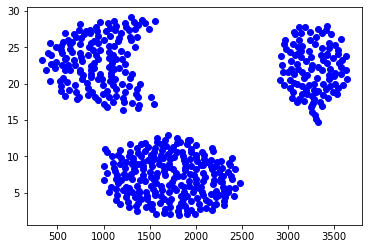

In [4]:
# 2D dataset

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="blue") # the data
plt.show()

By observing the visualization of the dataset, we can verify that 3 clusters would be adequate.

In [5]:
gmm = GMM(data=df_train.to_numpy(), n_clusters=3)

The clusters are initialy initialized with random points of the dataset provided for training.

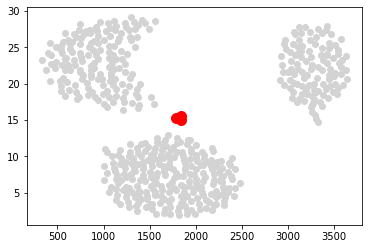

In [6]:
# initialize clusters and show their initial position in the chart    
fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="lightgray") # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

We use the clusters() method to get which cluster each data point has the highest probability of belonging

In [7]:
gmm.clusters()

array([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Initially without any fitting, the clusters provided are the following

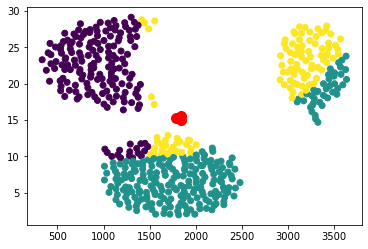

In [8]:
# initialize clusters and show their initial position in the chart

c = gmm.clusters()

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

In [9]:
gmm.fit()

converged in 5 iterations
--- 0.012622833251953125 seconds ---


### Results after fitting with the raw training data

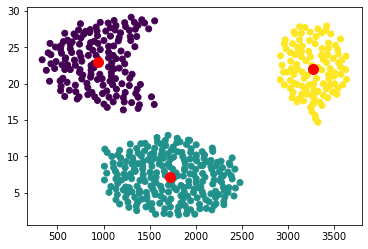

In [10]:
# Result of clusters after fitting is done

c = gmm.clusters()

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

As we can see, despite the fact that X and Y are on different scales, the GMM algorithm converged to optimal clusters even without a prior data normalization (unlike k-means)

## Checking the test data distribution

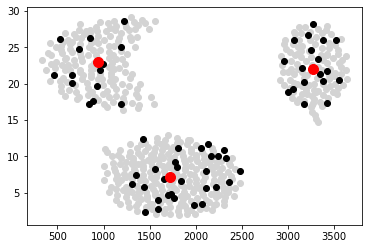

In [11]:
# the test data
fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="lightgray") # the data
ax.scatter(df_test.iloc[:,:1].values, df_test.iloc[:,1:].values, c="black") # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

## How the test data was classified using the prefitted gaussian mixture model

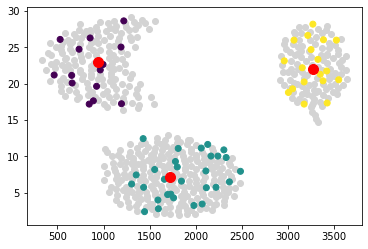

In [12]:
c = gmm.clusters(data=df_test.to_numpy())

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="lightgray") # the data
ax.scatter(df_test.iloc[:,:1].values, df_test.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

### Metrics

Now we will verify the results using a few metrics.

### The AIC/BIC Method
We'll run the GMM algorithm with different amounts of clusters and calculate the AIC and BIC metrics for every run, where:

AIC = -2*ln(L)+ p*ln(N)  
BIC = 2*p - 2*ln(L)

The actual value of these two metrics doesn't mean anything, we're only concerned with the diference between the two (We want the number of cluster that minimizes the diference between these metrics).

converged in 2 iterations
--- 0.0023641586303710938 seconds ---
converged in 3 iterations
--- 0.004969120025634766 seconds ---
converged in 4 iterations
--- 0.005197048187255859 seconds ---
converged in 3 iterations
--- 0.005197048187255859 seconds ---
converged in 5 iterations
--- 0.014901876449584961 seconds ---
converged in 13 iterations
--- 0.03680014610290527 seconds ---
converged in 4 iterations
--- 0.011512994766235352 seconds ---
converged in 8 iterations
--- 0.026102066040039062 seconds ---
converged in 9 iterations
--- 0.029078960418701172 seconds ---


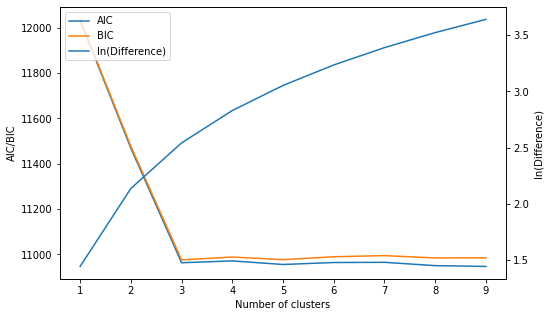

In [13]:
aic_values = []
bic_values = []
cluster_range = range(1, 10)
for i in cluster_range:
    gmm = GMM(data=df_train.to_numpy(), n_clusters=i)
    gmm.fit()
    aic_values.append(gmm.aic())
    bic_values.append(gmm.bic())

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.set_xlabel("Number of clusters")
ax.set_ylabel("AIC/BIC")
ax2.set_ylabel("ln(Difference)")
p1, = ax.plot(cluster_range, aic_values, label="AIC") # the data
p2, = ax.plot(cluster_range, bic_values, label="BIC") # the data
p3, = ax2.plot(cluster_range, np.log(np.subtract(bic_values, aic_values)), label="ln(Difference)") # the data
plt.legend(handles=[p1, p2, p3])
plt.show()

We can verify that the difference between the AIC and BIC methods starts to increase for n_clusters > 3 (also verified by the natural logarithm of the difference between AIC and BIC), so we can assume that 3 is the optimal number of clusters.

## Second problem
Now we'll tackle a problem with many more dimensions using clustering algorithms. As a proposed problem we'll attempt to solve the handwritten digits dataset using only unsupervised clustering.

We are using the skelearn digits dataset because it's an already scalled down version of the MNIST dataset, where each image has only 64 features, greatly reducing the time required to fit the models.

Since there are 10 classes in the dataset (the ten digits), an intuitive value for n_clusters would be 10, but we will validate that value using the analysis that we showed previously.

First we'll fetch the *digits* dataset from scikit, and do normalizations

Features 64
[[0.     0.     0.6875 ... 0.     0.     0.    ]
 [0.     0.0625 0.875  ... 0.3125 0.     0.    ]
 [0.     0.     0.625  ... 0.625  0.0625 0.    ]
 ...
 [0.     0.     0.5625 ... 0.875  0.3125 0.    ]
 [0.     0.0625 0.6875 ... 0.0625 0.     0.    ]
 [0.     0.     0.125  ... 0.     0.     0.    ]]


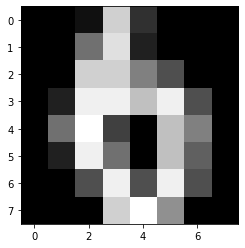

In [14]:
X, y = load_digits(return_X_y=True) # fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False) # 
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.1)
# since we know that the maximum value of a pixel in the dataset is 255, we'll just divide everything by 255 for scaling.
scalling_factor = np.max(X_train)
X_train = X_train / scalling_factor
X_test = X_test / scalling_factor
print("Features", X_train.shape[1])
print(X_test)

plt.imshow(X_train[2].reshape((8,8)), cmap='gray', vmin=0, vmax=1)
plt.show()

converged in 1 iterations
--- 0.006036043167114258 seconds ---
converged in 100 iterations
--- 0.7898952960968018 seconds ---
converged in 100 iterations
--- 1.1310970783233643 seconds ---
converged in 100 iterations
--- 1.4034709930419922 seconds ---
converged in 100 iterations
--- 1.7235782146453857 seconds ---
converged in 100 iterations
--- 2.277772903442383 seconds ---
converged in 100 iterations
--- 2.859133005142212 seconds ---
converged in 100 iterations
--- 2.991636037826538 seconds ---
converged in 100 iterations
--- 3.1994190216064453 seconds ---
converged in 100 iterations
--- 3.673704147338867 seconds ---
converged in 100 iterations
--- 3.7159130573272705 seconds ---
converged in 100 iterations
--- 4.357131004333496 seconds ---
converged in 100 iterations
--- 4.535732984542847 seconds ---
converged in 100 iterations
--- 4.721814155578613 seconds ---


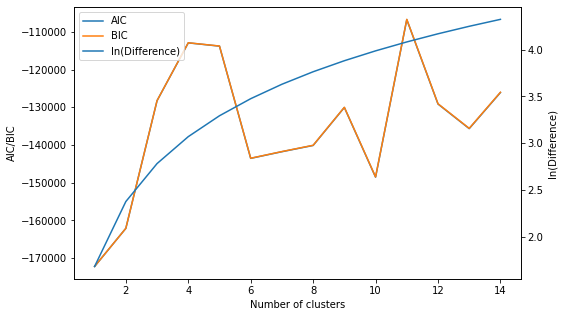

In [15]:
aic_values = []
bic_values = []
cluster_range = range(1, 15)
for i in cluster_range:
    gmm = GMM(data=X_train, n_clusters=i)
    gmm.fit()
    aic_values.append(gmm.aic())
    bic_values.append(gmm.bic())

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

ax.set_xlabel("Number of clusters")
ax.set_ylabel("AIC/BIC")
ax2.set_ylabel("ln(Difference)")
p1, = ax.plot(cluster_range, aic_values, label="AIC") # the data
p2, = ax.plot(cluster_range, bic_values, label="BIC") # the data
p3, = ax2.plot(cluster_range, np.log(np.subtract(bic_values, aic_values)), label="ln(Difference)") # the data
plt.legend(handles=[p1, p2, p3])
plt.show()

From the AIC/BIC, we would assume that the optimal amount of clusters would be between 11 and 12. After testing, the best results were achieved with 12 clusters.

We'll run the clustering 30 times and consider the one with the lowest difference between AIC and BIC

In [16]:
# We'll run the method 30 times, and consider the one with the lowest difference between AIC and BIC
models = []
for i in range(30):
    gmm = GMM(data=X_train, n_clusters=10)
    gmm.fit()
    models.append(gmm)

lowest_difference = math.inf
best_gmm = None
for gmm in models:
    difference = abs(gmm.aic() - gmm.bic())
    if difference < lowest_difference:
        lowest_difference = difference
        best_gmm = gmm

print("Difference between AIC and BIC:", lowest_difference)

converged in 100 iterations
--- 3.757664680480957 seconds ---
converged in 100 iterations
--- 3.9024930000305176 seconds ---
converged in 100 iterations
--- 3.944207191467285 seconds ---
converged in 100 iterations
--- 3.6664960384368896 seconds ---
converged in 100 iterations
--- 3.350696325302124 seconds ---
converged in 100 iterations
--- 3.6596970558166504 seconds ---
converged in 100 iterations
--- 3.5479249954223633 seconds ---
converged in 100 iterations
--- 3.616251230239868 seconds ---
converged in 100 iterations
--- 3.7792162895202637 seconds ---
converged in 100 iterations
--- 3.739185333251953 seconds ---
converged in 100 iterations
--- 3.233705997467041 seconds ---
converged in 100 iterations
--- 3.4053213596343994 seconds ---
converged in 100 iterations
--- 3.6406447887420654 seconds ---
converged in 100 iterations
--- 3.598951816558838 seconds ---
converged in 100 iterations
--- 3.4561986923217773 seconds ---
converged in 100 iterations
--- 3.518906831741333 seconds ---


Since clustering is an unsupervised learning method, we'll need to check which of the labels corresponds to each cluster found.

We'll do that by considering the label that appears more often in the cluster being observed

In [17]:
# since clustering is a unsupervised learning method, we'll need to check which of the labels corresponds to each cluster found
clusters = best_gmm.clusters()
labels_by_cluster = []
for i in range(best_gmm.means.shape[0]):
    bins = np.bincount(y_train[clusters == i])
    label_for_cluster = 0
    if bins.shape[0] > 0:
        label_for_cluster = bins.argmax() # the most common label to appear in the current cluster
    labels_by_cluster.append(label_for_cluster)
print(labels_by_cluster)

[6, 7, 6, 0, 2, 5, 2, 4, 0, 7]


With the labels of each cluster found, let's validate the results found using the test data.

In [18]:
clusters = best_gmm.clusters(data=X_test) 
success = 0
for i in range(y_test.shape[0]):
    if y_test[i] == labels_by_cluster[clusters[i]]:
        success += 1

print(f"Successes: {success} out of {y_test.shape[0]}")
print(f"Successes rate: {success/y_test.shape[0]}")

Successes: 34 out of 180
Successes rate: 0.18888888888888888


### Applying PCA
To allow for an easier visualization of the clustered data, we'll use PCA to decompose the data into 2 features. So we can visualize 2D scatter plots of the clustering proccess.

In [19]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
df_train_pca = pca.transform(X_train)
df_test_pca = pca.transform(X_test)

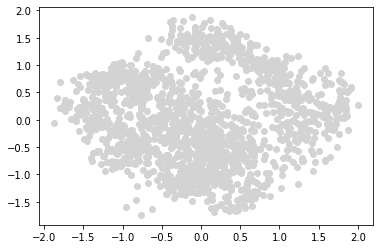

In [20]:
fig, ax = plt.subplots()
ax.scatter(df_train_pca[:,:1], df_train_pca[:,1:], c="lightgray") # the data
plt.show()

### Original Data Labeling
Let's check how the labels of the training data are distributed in the scatter

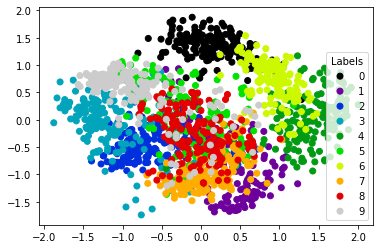

In [21]:
fig, ax = plt.subplots()
colors = cm.nipy_spectral(y_train.astype(float) / y_train.max())
for i in range(10):
    mask = y_train == i
    ax.scatter(df_train_pca[mask][:,:1], df_train_pca[mask][:,1:], c=colors[mask], label=i) # the data

ax.legend(loc="lower right", title="Labels")

plt.show()

As we can observe, for most features the data is well separated, with the exceptions of the data with labels 5 and 8 that are overlapped. So we would expect most mistakes from the model to happen with those two labels.

In [22]:
models = []
for i in range(30):
    gmm = GMM(data=df_train_pca, n_clusters=10)
    gmm.fit()
    models.append(gmm)

lowest_difference = math.inf
gmm_pca = None
for gmm in models:
    difference = abs(gmm.aic() - gmm.bic())
    if difference < lowest_difference:
        lowest_difference = difference
        gmm_pca = gmm

print("Difference between AIC and BIC:", lowest_difference)

converged in 21 iterations
--- 0.21351408958435059 seconds ---
converged in 21 iterations
--- 0.09594988822937012 seconds ---
converged in 15 iterations
--- 0.07424688339233398 seconds ---
converged in 28 iterations
--- 0.1809828281402588 seconds ---
converged in 27 iterations
--- 0.14821505546569824 seconds ---
converged in 12 iterations
--- 0.0662071704864502 seconds ---
converged in 40 iterations
--- 0.22248291969299316 seconds ---
converged in 21 iterations
--- 0.10672211647033691 seconds ---
converged in 24 iterations
--- 0.111785888671875 seconds ---
converged in 39 iterations
--- 0.16556477546691895 seconds ---
converged in 14 iterations
--- 0.06077098846435547 seconds ---
converged in 28 iterations
--- 0.12316012382507324 seconds ---
converged in 17 iterations
--- 0.07373189926147461 seconds ---
converged in 21 iterations
--- 0.1094663143157959 seconds ---
converged in 35 iterations
--- 0.15422606468200684 seconds ---
converged in 10 iterations
--- 0.04523897171020508 seconds -

In [23]:
# since clustering is a unsupervised learning method, we'll need to check which of the labels corresponds to each cluster found
clusters = gmm_pca.clusters()
pca_labels_by_cluster = []
for i in range(gmm_pca.means.shape[0]):
    bins = np.bincount(y_train[clusters == i])
    label_for_cluster = 0
    if bins.shape[0] > 0:
        label_for_cluster = bins.argmax() # the most common label to appear in the current cluster
    pca_labels_by_cluster.append(label_for_cluster)
print(pca_labels_by_cluster)

[2, 5, 8, 9, 6, 7, 9, 0, 0, 9]


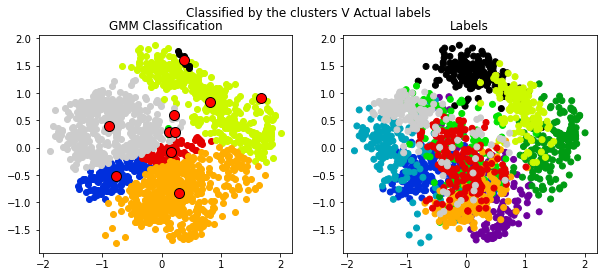

In [24]:
# Result of clusters after fitting is done

c = gmm_pca.clusters()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle('Classified by the clusters V Actual labels', fontsize=12)

# ax1.scatter(df_train_pca[:,:1], df_train_pca[:,1:], c=c) # the data

for i in range(gmm_pca.means.shape[0]):
    mask = c == i
    label = pca_labels_by_cluster[i]
    color = cm.nipy_spectral(label / y_train.max())
    ax1.scatter(df_train_pca[mask][:,:1], df_train_pca[mask][:,1:], color=color) # the data

colors = cm.nipy_spectral(y_train.astype(float) / y_train.max())
for i in range(10):
    mask = y_train == i
    ax2.scatter(df_train_pca[mask][:,:1], df_train_pca[mask][:,1:], c=colors[mask]) # the data

ax1.scatter(gmm_pca.means[:,:1], gmm_pca.means[:,1:], c="red", s=100, edgecolors='k') # the data

ax1.title.set_text('GMM Classification')
ax2.title.set_text('Labels')

plt.show()

So we confirm the results found in the previous result. Even though the training is unsupervised, the difference in the images of the handwritten digits are enough that distinct clusters can be found with reasonably small overlapping.

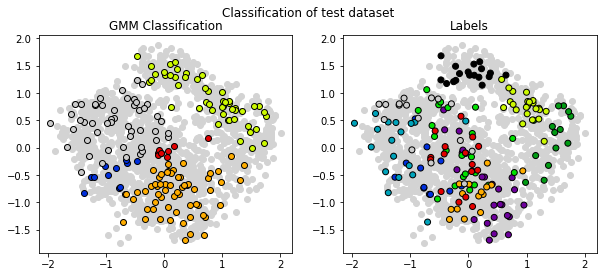

In [25]:
c = gmm_pca.clusters(data=df_test_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Classification of test dataset', fontsize=12)

ax1.scatter(df_train_pca[:,:1], df_train_pca[:,1:], c="lightgray") # the data
ax2.scatter(df_train_pca[:,:1], df_train_pca[:,1:], c="lightgray") # the data

for i in range(gmm_pca.means.shape[0]):
    mask = c == i
    label = pca_labels_by_cluster[i]
    color = cm.nipy_spectral(label / y_test.max())
    ax1.scatter(df_test_pca[mask][:,:1], df_test_pca[mask][:,1:], color=color, edgecolors='k') # the data

colors = cm.nipy_spectral(y_test.astype(float) / y_test.max())
for i in range(10):
    mask = y_test == i
    ax2.scatter(df_test_pca[mask][:,:1], df_test_pca[mask][:,1:], c=colors[mask], edgecolors='k') # the data

ax1.title.set_text('GMM Classification')
ax2.title.set_text('Labels')
plt.show()

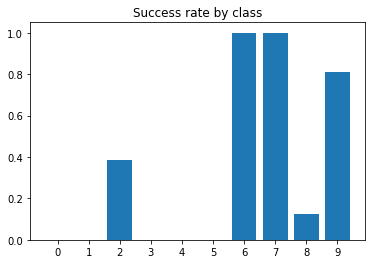

In [26]:
c = gmm_pca.clusters(data=df_test_pca)
successes = np.empty(10) 
for i in range(10):
    mask = y_test == i
    f = np.vectorize(lambda x: pca_labels_by_cluster[x])
    l = f(c[mask])
    s = np.sum(l == i)
    successes[i] = s / np.sum(mask)

fig, ax = plt.subplots()

ax.bar(range(10), successes) # the data
ax.set_xticks(np.arange(10))
ax.title.set_text('Success rate by class')
plt.show()

As expected, since the data for the labels "5" and "8" where considerably overlapped, the classification for the label "5" had by far the worst result when compared to the others.

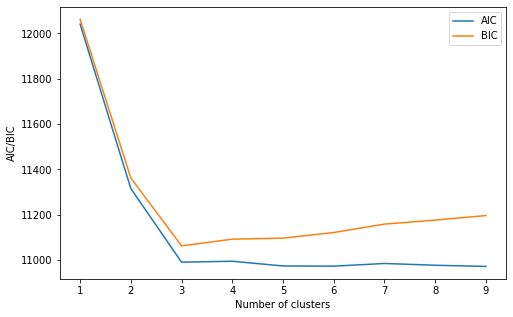

In [27]:
aic_values = []
bic_values = []
cluster_range = range(1, 10)
train = df_train.to_numpy()
for i in cluster_range:
    gm = GaussianMixture(n_components=i).fit(train)
    aic_values.append(gm.aic(train))
    bic_values.append(gm.bic(train))

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("Number of clusters")
ax.set_ylabel("AIC/BIC")
p1, = ax.plot(cluster_range, aic_values, label="AIC") # the data
p2, = ax.plot(cluster_range, bic_values, label="BIC") # the data
plt.legend(handles=[p1, p2])
plt.show()

In [28]:
n_clusters = 3
data = df_train.to_numpy()
points = np.random.RandomState(None).permutation(data)[:n_clusters]
means = []
covs = []
for p in points:
    means = np.append(means, p)
    covs = np.append(covs, np.cov(p))
means = means.reshape(n_clusters, 2)

probabilities = np.array([])
for i in range(0, n_clusters):
    var = multivariate_normal(mean=means[i], cov=covs[i], allow_singular=True)
    probabilities = np.append(probabilities, np.array([var.pdf(d) for d in data]))

probabilities = probabilities.reshape((n_clusters, len(data)))
probabilities = probabilities.T
print(data[0])
print(probabilities)

np.argmax(probabilities, axis=1)

[1555.     28.65]
[[1.97606482e-07 2.20024114e-07 2.62296270e-08]
 [2.02583005e-07 2.52043974e-07 2.56677188e-08]
 [2.05416153e-07 2.74821347e-07 2.52724713e-08]
 ...
 [7.75915968e-09 1.31395017e-11 3.32360424e-08]
 [5.64223755e-09 5.58095338e-12 3.29251227e-08]
 [8.35285032e-09 1.60316583e-11 3.32990717e-08]]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,